In [1]:
data_dir = "imagebin"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
batch_size = 32
img_height = 225
img_width = 300

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10015 files belonging to 2 classes.
Using 8012 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10015 files belonging to 2 classes.
Using 2003 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['benign', 'malignant']


In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 225, 300, 3)
(32,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = layers.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.13333334 0.77156866


In [12]:
num_classes = len(class_names)

In [13]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.9),
    layers.RandomZoom(0.6),
  ]
)

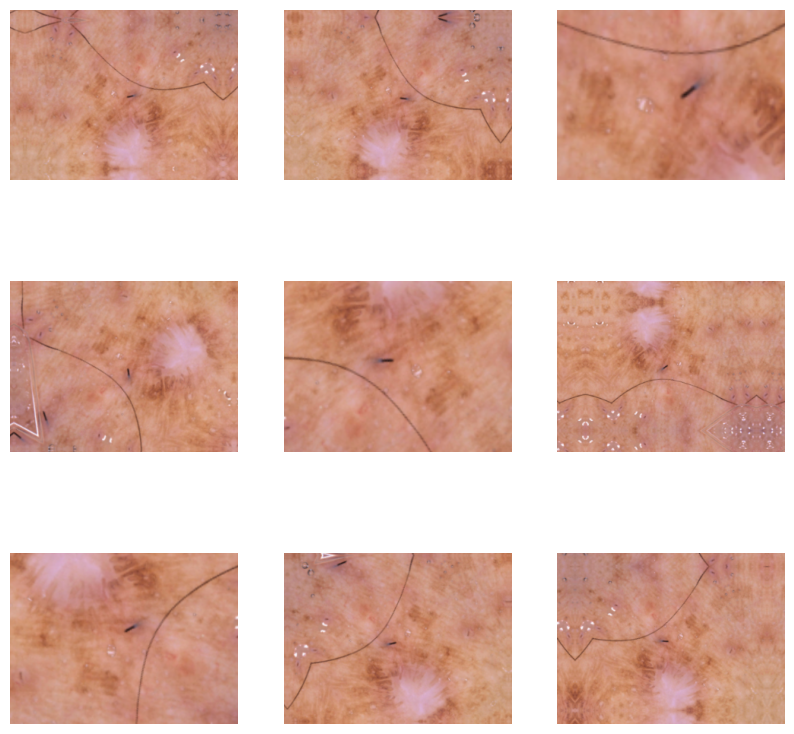

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [15]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.6),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
251/251 [==============================] - 114s 350ms/step - loss: 0.4671 - accuracy: 0.8013 - val_loss: 0.4111 - val_accuracy: 0.8088
Epoch 2/25
251/251 [==============================] - 86s 342ms/step - loss: 0.4229 - accuracy: 0.8039 - val_loss: 0.4613 - val_accuracy: 0.8088
Epoch 3/25
251/251 [==============================] - 88s 350ms/step - loss: 0.4174 - accuracy: 0.8039 - val_loss: 0.3822 - val_accuracy: 0.8088
Epoch 4/25
251/251 [==============================] - 84s 335ms/step - loss: 0.4146 - accuracy: 0.8039 - val_loss: 0.4078 - val_accuracy: 0.8088
Epoch 5/25
251/251 [==============================] - 89s 354ms/step - loss: 0.4028 - accuracy: 0.8039 - val_loss: 0.3818 - val_accuracy: 0.8088
Epoch 6/25
251/251 [==============================] - 82s 326ms/step - loss: 0.4052 - accuracy: 0.8039 - val_loss: 0.3815 - val_accuracy: 0.8088
Epoch 7/25
251/251 [==============================] - 82s 327ms/step - loss: 0.3869 - accuracy: 0.8039 - val_loss: 0.3912 - val_a

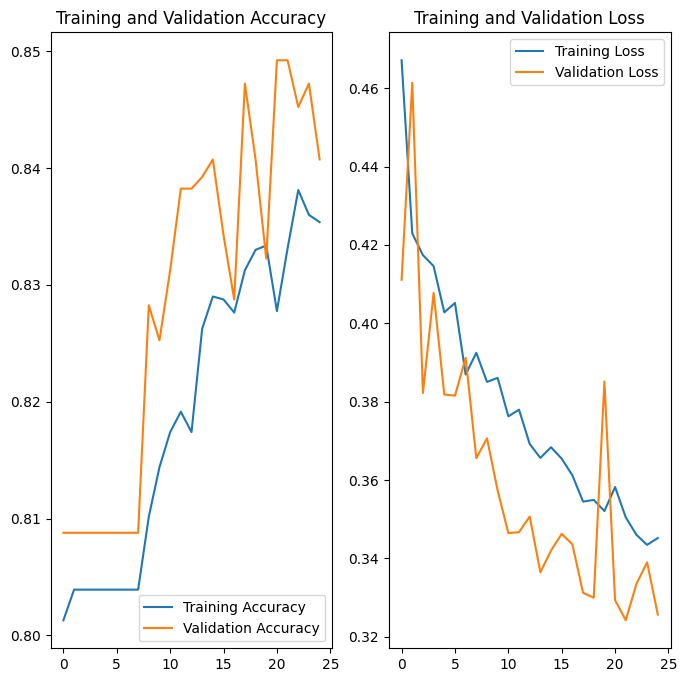

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
model.save('image_classifier.h5')